# Prédiction d'Investissement avec Chronos-2 et Moirai-2

Ce notebook utilise les modèles **Chronos-2** et **Moirai-2** pour prédire les investissements trimestriels des pays européens.

## Contenu
1. Configuration et chargement des données
2. Préparation des données
3. Prédictions avec Chronos-2
4. Prédictions avec Moirai-2
5. Comparaison des résultats
6. Visualisations


## 1. Configuration et imports

**Note**: Nous ajoutons le répertoire parent au chemin Python pour importer nos modules personnalisés.


In [1]:
# Ajouter le répertoire racine du projet au chemin Python
import sys
from pathlib import Path

# Remonter au répertoire parent (racine du projet)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Imports standards
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Imports depuis le module ecb_forecast.compare
from ecb_forecast.compare import (
    Chronos2Runner,
    Moirai2Runner,
    merge_results,
    resolve_device,
    parse_torch_dtype
)
from ecb_forecast.datasets import (
    load_quarterly_dataset,
    compute_country_stats,
    prepare_country_context,
    prepare_moirai_inputs,
)

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports réussis!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponible: {resolve_device('auto')}")


✅ Imports réussis!
PyTorch version: 2.4.1
Device disponible: mps


## 2. Chargement des données


In [2]:
# Chemins des données (relatifs à la racine du projet)
DATA_DIR = project_root / "data" / "processed"
COMBINED_FILE = DATA_DIR / "investment_quarterly.csv"

# Colonnes dans les données
ID_COLUMN = "country"
TIMESTAMP_COLUMN = "timestamp"
TARGET_COLUMN = "investment"

# Chargement du fichier combiné
df_full, dataset_summary = load_quarterly_dataset(
    COMBINED_FILE,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
)

print(f"📊 Données chargées: {dataset_summary.num_rows} observations")
print(f"Pays disponibles: {dataset_summary.series_ids}")
print(
    f"Période: {dataset_summary.start.date()} → {dataset_summary.end.date()}"
)
print(f"\nAperçu des données:")
df_full.head()


📊 Données chargées: 496 observations
Pays disponibles: ['DE', 'ES', 'FR', 'IT']
Période: 1995-01-01 → 2025-10-01

Aperçu des données:


,country,investment,investment_qoq,gdp,gdp_qoq,capacityprod_kg,capacityprod_ind,capacityutil_ind,capacityutil_kg,production_kg,...,confidence_kg,orders_kg,exportorders_kg,expectedprod_kg,confidence_ind,orders_ind,exportorders_ind,expectedprod_ind,eei,timestamp
0,DE,31184.89,NaN,635687.43,NaN,11.2,13.9,84.349361,90.940051,NaN,...,0.867608,-16.780977,-20.133333,22.283802,-1.890940,-16.496572,-27.814179,14.333097,95.266918,1995-01-01
1,DE,31017.59,-0.537922,640777.12,0.797471,27.2,16.0,84.555137,85.447164,NaN,...,-4.223661,-15.364925,-18.300000,6.527275,-6.286330,-17.222819,-29.793289,5.311969,99.179924,1995-04-01
2,DE,31647.75,2.011259,642071.09,0.201734,23.4,17.0,83.993828,83.946850,NaN,...,-4.378024,-17.168103,-15.400000,7.434031,-10.505105,-22.983488,-30.462502,1.416328,98.259968,1995-07-01
3,DE,32071.58,1.330322,642329.89,0.040299,24.2,22.2,83.640921,86.561694,NaN,...,-2.832566,-16.479279,-18.266667,9.448246,-12.659780,-27.401496,-33.230317,1.011395,93.585268,1995-10-01
4,DE,31569.64,-1.577438,637758.07,-0.714301,26.6,27.4,82.072253,83.743998,NaN,...,-13.421682,-27.405455,-21.900000,-6.392925,-20.115165,-36.576565,-37.828439,-6.917419,93.294153,1996-01-01


In [3]:
# Afficher quelques statistiques par pays
print("📈 Statistiques par pays:\n")
country_stats = compute_country_stats(
    df_full,
    id_column=ID_COLUMN,
    target_column=TARGET_COLUMN,
)
for stat in country_stats:
    print(
        f"{stat.series_id}: {stat.observations} observations | Moyenne: {stat.mean:.0f} | "
        f"Std: {stat.std:.0f} | Coverage: {stat.coverage:.1%}"
    )


📈 Statistiques par pays:

DE: 124 observations | Moyenne: 48984 | Std: 9133 | Coverage: 98.4%
ES: 124 observations | Moyenne: 15987 | Std: 2956 | Coverage: 99.2%
FR: 124 observations | Moyenne: 27024 | Std: 3993 | Coverage: 99.2%
IT: 124 observations | Moyenne: 30747 | Std: 3697 | Coverage: 95.2%


## 3. Configuration des modèles

Configurez les paramètres de prédiction ici :


In [4]:
# ========== PARAMÈTRES À AJUSTER ==========

# Pays à prédire (choix: 'DE', 'ES', 'FR', 'IT')
TARGET_COUNTRY = "DE"

# Date de fin des données d'entraînement (début de la période de prévision)
# Les prédictions commenceront après cette date
CUTOFF_DATE = "2020-12-31"

# Horizon de prédiction (nombre de trimestres)
# De 2021-Q1 (2021-01-01) à 2025-Q1 (2025-03-31) = 17 trimestres
PREDICTION_LENGTH = 17

# Niveaux de quantiles pour les intervalles de confiance
QUANTILE_LEVELS = [0.1, 0.5, 0.9]

# Modèles à utiliser
CHRONOS_MODEL = "amazon/chronos-2"
MOIRAI_MODEL = "Salesforce/moirai-2.0-R-small"

# Paramètres de génération pour Moirai
MOIRAI_SAMPLES = 16
TEMPERATURE = 0.8
TOP_P = 0.9
TOP_K = 50

# Device et dtype
DEVICE = "auto"  # 'auto', 'cpu', 'cuda', or 'mps'
CHRONOS_DTYPE = "auto"  # 'auto', 'float32', 'float16', or 'bfloat16'
MOIRAI_DTYPE = "bfloat16"

print(f"🎯 Configuration:")
print(f"  Pays cible: {TARGET_COUNTRY}")
print(f"  Date de coupure: {CUTOFF_DATE}")
print(f"  Horizon: {PREDICTION_LENGTH} trimestres")
print(f"  Période de prévision: 2021-Q1 à 2025-Q1")
print(f"  Quantiles: {QUANTILE_LEVELS}")
print(f"  Device: {resolve_device(DEVICE)}")


🎯 Configuration:
  Pays cible: DE
  Date de coupure: 2020-12-31
  Horizon: 17 trimestres
  Période de prévision: 2021-Q1 à 2025-Q1
  Quantiles: [0.1, 0.5, 0.9]
  Device: mps


## 4. Préparation des données pour le pays sélectionné


In [5]:
# Filtrer les données jusqu'à la date de coupure
cutoff_timestamp = pd.to_datetime(CUTOFF_DATE)
df_filtered = df_full[df_full[TIMESTAMP_COLUMN] <= cutoff_timestamp].copy()

print(f"📅 Filtrage des données jusqu'au {CUTOFF_DATE}")
print(f"  Données complètes: {len(df_full)} lignes")
print(f"  Données filtrées: {len(df_filtered)} lignes")

# Sélectionner les données du pays cible
country_context = prepare_country_context(
    df_filtered,
    prediction_length=PREDICTION_LENGTH,
    series_id=TARGET_COUNTRY,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
    target_column=TARGET_COLUMN,
)

context_df = country_context.dataframe
series_id = country_context.series_id
context_offset = country_context.offset
forecast_index = country_context.forecast_index

print(f"\n📋 Données contextuelles pour {series_id}:")
print(f"  Nombre d'observations: {len(context_df)}")
print(
    f"  Période: {context_df[TIMESTAMP_COLUMN].min().date()} → "
    f"{context_df[TIMESTAMP_COLUMN].max().date()}"
)
print(
    f"  Valeurs d'investissement: min={context_df[TARGET_COLUMN].min():.0f}, "
    f"max={context_df[TARGET_COLUMN].max():.0f}"
)

print(f"\n🔮 Prédictions pour les trimestres (T+1 à T+{PREDICTION_LENGTH}):")
print(f"  Premier: {forecast_index[0].date()}")
print(f"  Dernier: {forecast_index[-1].date()}")
if PREDICTION_LENGTH <= 10:
    for i, date in enumerate(forecast_index, 1):
        print(f"  T+{i}: {date.date()}")
else:
    for i, date in enumerate(forecast_index[:5], 1):
        print(f"  T+{i}: {date.date()}")
    print(f"  ...")
    for i, date in enumerate(forecast_index[-5:], PREDICTION_LENGTH-4):
        print(f"  T+{i}: {date.date()}")

print(f"\n📊 Dernières valeurs historiques:")
context_df.tail(10)


📅 Filtrage des données jusqu'au 2020-12-31
  Données complètes: 496 lignes
  Données filtrées: 416 lignes

📋 Données contextuelles pour DE:
  Nombre d'observations: 104
  Période: 1995-01-01 → 2020-10-01
  Valeurs d'investissement: min=31018, max=64419

🔮 Prédictions pour les trimestres (T+1 à T+17):
  Premier: 2021-01-01
  Dernier: 2025-01-01
  T+1: 2021-01-01
  T+2: 2021-04-01
  T+3: 2021-07-01
  T+4: 2021-10-01
  T+5: 2022-01-01
  ...
  T+13: 2024-01-01
  T+14: 2024-04-01
  T+15: 2024-07-01
  T+16: 2024-10-01
  T+17: 2025-01-01

📊 Dernières valeurs historiques:


,country,timestamp,investment
94,DE,2018-07-01,62266.64
95,DE,2018-10-01,62578.92
96,DE,2019-01-01,64307.62
97,DE,2019-04-01,64419.15
98,DE,2019-07-01,63292.70
99,DE,2019-10-01,61709.00
100,DE,2020-01-01,57450.03
101,DE,2020-04-01,49397.43
102,DE,2020-07-01,56697.20
103,DE,2020-10-01,58197.29


## 5. Visualisation des données historiques


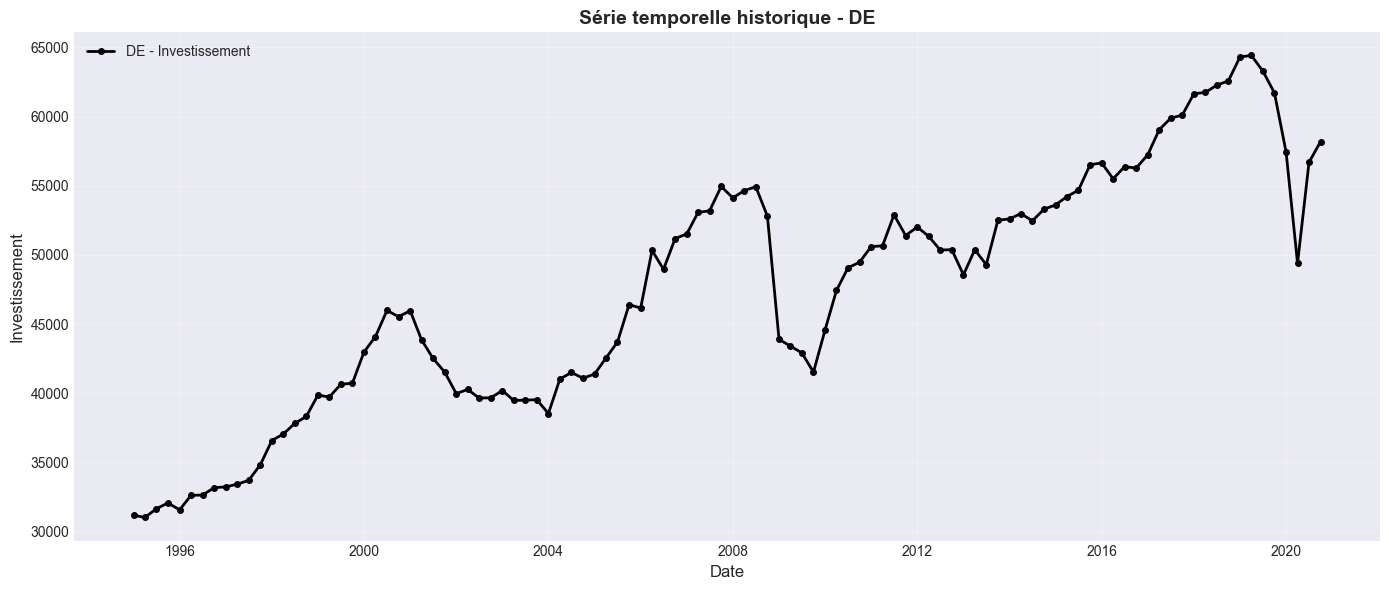


📊 Statistiques descriptives:
count      104.000000
mean     47330.762788
std       8869.219482
min      31017.590000
25%      40254.307500
50%      48760.480000
75%      53740.250000
max      64419.150000
Name: investment, dtype: float64


In [6]:
# Graphique de la série temporelle
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(context_df[TIMESTAMP_COLUMN], context_df[TARGET_COLUMN], 
        marker='o', linewidth=2, markersize=4, label=f'{TARGET_COUNTRY} - Investissement', color='black')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Investissement', fontsize=12)
ax.set_title(f'Série temporelle historique - {TARGET_COUNTRY}', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques descriptives
print("\n📊 Statistiques descriptives:")
print(context_df[TARGET_COLUMN].describe())


## 6. Prédiction avec Chronos-2

Chronos-2 est un modèle de prévision de séries temporelles pré-entraîné développé par Amazon.


In [7]:
print("🔄 Chargement du modèle Chronos-2...")

# Initialiser le modèle Chronos
chronos_device = resolve_device(DEVICE)
chronos_dtype = parse_torch_dtype(CHRONOS_DTYPE)

chronos_runner = Chronos2Runner(
    model_name=CHRONOS_MODEL,
    device_map=chronos_device,
    dtype=chronos_dtype
)

print("✅ Modèle Chronos-2 chargé!")
print(f"   Device: {chronos_device}")
print(f"   Dtype: {chronos_dtype}")


🔄 Chargement du modèle Chronos-2...


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


✅ Modèle Chronos-2 chargé!
   Device: mps
   Dtype: auto


In [8]:
print("🔮 Génération des prédictions Chronos-2...")

# Faire les prédictions
chronos_result = chronos_runner.run(
    context_df=context_df,
    prediction_length=PREDICTION_LENGTH,
    quantile_levels=QUANTILE_LEVELS,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
    target_column=TARGET_COLUMN
)

print(f"✅ Prédictions Chronos-2 terminées en {chronos_result.elapsed_s:.2f}s")
print(f"\n📊 Aperçu des prédictions Chronos-2:")
chronos_result.df


🔮 Génération des prédictions Chronos-2...


✅ Prédictions Chronos-2 terminées en 3.49s

📊 Aperçu des prédictions Chronos-2:


,timestamp,chronos_p10,chronos_p50,chronos_p90
0,2021-01-01,55524.835938,58518.828125,60987.937500
1,2021-04-01,55224.957031,59236.386719,62497.253906
2,2021-07-01,55231.289062,59757.898438,63732.390625
3,2021-10-01,54633.203125,60014.652344,64617.085938
4,2022-01-01,54435.832031,60237.394531,65217.429688
5,2022-04-01,54288.390625,60344.851562,65611.390625
6,2022-07-01,54174.878906,60650.542969,66030.507812
7,2022-10-01,54216.210938,60992.156250,66636.656250
8,2023-01-01,54378.246094,61303.871094,67419.562500
9,2023-04-01,54347.464844,61670.367188,67602.156250


## 7. Prédiction avec Moirai-2

Moirai-2 est un modèle de langage adapté pour les séries temporelles développé par Salesforce.


In [9]:
print("🔄 Chargement du modèle Moirai-2...")

# Initialiser le modèle Moirai
# Note: MPS ne supporte pas float64, donc on force CPU pour Moirai sur Mac
moirai_device = resolve_device(DEVICE)
if moirai_device == "mps":
    print("⚠️  MPS détecté - utilisation de CPU pour Moirai-2 (meilleure compatibilité)")
    moirai_device = "cpu"

moirai_dtype = parse_torch_dtype(MOIRAI_DTYPE)

moirai_runner = Moirai2Runner(
    model_name=MOIRAI_MODEL,
    device_map=moirai_device,
    dtype=moirai_dtype
)

print("✅ Modèle Moirai-2 chargé!")
print(f"   Device: {moirai_device}")
print(f"   Dtype: {moirai_dtype}")


🔄 Chargement du modèle Moirai-2...
⚠️  MPS détecté - utilisation de CPU pour Moirai-2 (meilleure compatibilité)
✅ Modèle Moirai-2 chargé!
   Device: cpu
   Dtype: torch.bfloat16


In [10]:
print("🔮 Génération des prédictions Moirai-2...")

# Préparer les entrées pour Moirai-2
context_values, start_timestamp, freq = prepare_moirai_inputs(
    context_df,
    timestamp_column=TIMESTAMP_COLUMN,
    target_column=TARGET_COLUMN,
)

print(f"📅 Fréquence utilisée: {freq}")
print(f"📅 Premier timestamp ajusté: {start_timestamp}")
print(f"📅 Nombre de valeurs: {len(context_values)}")

# Faire les prédictions
moirai_result = moirai_runner.run(
    values=context_values,
    prediction_length=PREDICTION_LENGTH,
    quantile_levels=QUANTILE_LEVELS,
    forecast_index=forecast_index,
    start_timestamp=start_timestamp,
    freq=freq
)

print(f"✅ Prédictions Moirai-2 terminées en {moirai_result.elapsed_s:.2f}s")
print(f"\n📊 Aperçu des prédictions Moirai-2:")
moirai_result.df


The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.


🔮 Génération des prédictions Moirai-2...
📅 Fréquence utilisée: 3M
📅 Premier timestamp ajusté: 1995-01-01 00:00:00
📅 Nombre de valeurs: 104
✅ Prédictions Moirai-2 terminées en 0.01s

📊 Aperçu des prédictions Moirai-2:


,timestamp,moirai_p10,moirai_p50,moirai_p90,moirai_mean
0,2021-01-01,53215.886719,57534.367188,61504.871094,57534.367188
1,2021-04-01,51428.304688,57400.113281,62532.062500,57400.113281
2,2021-07-01,50014.484375,57129.488281,62919.664062,57129.488281
3,2021-10-01,49307.007812,57231.507812,63496.878906,57231.507812
4,2022-01-01,48391.179688,57033.863281,63695.375000,57033.863281
5,2022-04-01,48066.273438,57202.125000,63917.414062,57202.125000
6,2022-07-01,47475.609375,57119.656250,64064.804688,57119.656250
7,2022-10-01,46995.832031,56995.542969,64038.742188,56995.542969
8,2023-01-01,46517.539062,56882.402344,64444.675781,56882.402344
9,2023-04-01,46082.191406,56516.105469,64291.664062,56516.105469


## 8. Extraction des valeurs réelles (Ground Truth)


In [11]:
# Extraire les valeurs réelles pour la période de prédiction
ground_truth_df = df_full[
    (df_full[ID_COLUMN] == TARGET_COUNTRY) &
    (df_full[TIMESTAMP_COLUMN].isin(forecast_index))
].copy()

ground_truth_df = ground_truth_df.sort_values(TIMESTAMP_COLUMN)

print(f"📊 Valeurs réelles (Ground Truth) pour {TARGET_COUNTRY}:")
print(f"  Période: {ground_truth_df[TIMESTAMP_COLUMN].min().date()} → {ground_truth_df[TIMESTAMP_COLUMN].max().date()}")
print(f"  Nombre de valeurs: {len(ground_truth_df)}")
print(f"\n{ground_truth_df[[TIMESTAMP_COLUMN, TARGET_COLUMN]]}")

# Créer un dictionnaire pour faciliter la fusion
ground_truth_dict = dict(zip(ground_truth_df[TIMESTAMP_COLUMN], ground_truth_df[TARGET_COLUMN]))


📊 Valeurs réelles (Ground Truth) pour DE:
  Période: 2021-01-01 → 2025-01-01
  Nombre de valeurs: 17

     timestamp  investment
104 2021-01-01    57443.01
105 2021-04-01    58786.93
106 2021-07-01    56216.19
107 2021-10-01    57219.96
108 2022-01-01    58145.65
109 2022-04-01    59852.04
110 2022-07-01    61937.63
111 2022-10-01    61101.16
112 2023-01-01    60472.42
113 2023-04-01    60438.95
114 2023-07-01    60890.67
115 2023-10-01    59552.28
116 2024-01-01    59009.99
117 2024-04-01    57153.03
118 2024-07-01    56567.50
119 2024-10-01    56556.34
120 2025-01-01    56667.87


## 9. Comparaison des résultats avec Ground Truth


In [12]:
# Fusionner les résultats des modèles
merged_df = merge_results(
    chronos=chronos_result,
    moirai=moirai_result,
    timestamp_column=TIMESTAMP_COLUMN
)

# Ajouter les valeurs réelles
merged_df['actual'] = merged_df[TIMESTAMP_COLUMN].map(ground_truth_dict)

print("📊 Comparaison des prédictions avec valeurs réelles:")
print(merged_df)

# Calculer les erreurs pour chaque modèle (uniquement pour les valeurs disponibles)
mask = merged_df['actual'].notna()

if mask.sum() > 0:
    print(f"\n📏 Métriques d'erreur (sur {mask.sum()} points avec valeurs réelles):\n")
    
    # Chronos-2
    if 'chronos_p50' in merged_df.columns:
        chronos_mae = np.abs(merged_df.loc[mask, 'chronos_p50'] - merged_df.loc[mask, 'actual']).mean()
        chronos_rmse = np.sqrt(((merged_df.loc[mask, 'chronos_p50'] - merged_df.loc[mask, 'actual']) ** 2).mean())
        chronos_mape = (np.abs((merged_df.loc[mask, 'actual'] - merged_df.loc[mask, 'chronos_p50']) / merged_df.loc[mask, 'actual']).mean() * 100)
        
        print(f"🔵 Chronos-2:")
        print(f"  MAE (Mean Absolute Error):       {chronos_mae:.2f}")
        print(f"  RMSE (Root Mean Square Error):   {chronos_rmse:.2f}")
        print(f"  MAPE (Mean Absolute % Error):    {chronos_mape:.2f}%")
    
    # Moirai-2
    if 'moirai_p50' in merged_df.columns:
        moirai_mae = np.abs(merged_df.loc[mask, 'moirai_p50'] - merged_df.loc[mask, 'actual']).mean()
        moirai_rmse = np.sqrt(((merged_df.loc[mask, 'moirai_p50'] - merged_df.loc[mask, 'actual']) ** 2).mean())
        moirai_mape = (np.abs((merged_df.loc[mask, 'actual'] - merged_df.loc[mask, 'moirai_p50']) / merged_df.loc[mask, 'actual']).mean() * 100)
        
        print(f"\n🔴 Moirai-2:")
        print(f"  MAE (Mean Absolute Error):       {moirai_mae:.2f}")
        print(f"  RMSE (Root Mean Square Error):   {moirai_rmse:.2f}")
        print(f"  MAPE (Mean Absolute % Error):    {moirai_mape:.2f}%")
    
    # Comparaison
    if 'chronos_p50' in merged_df.columns and 'moirai_p50' in merged_df.columns:
        print(f"\n📊 Meilleur modèle:")
        if chronos_mae < moirai_mae:
            print(f"  ✅ Chronos-2 est plus précis (MAE: {chronos_mae:.2f} vs {moirai_mae:.2f})")
        else:
            print(f"  ✅ Moirai-2 est plus précis (MAE: {moirai_mae:.2f} vs {chronos_mae:.2f})")
else:
    print("\n⚠️ Aucune valeur réelle disponible pour la période de prédiction")


📊 Comparaison des prédictions avec valeurs réelles:
    timestamp   chronos_p10   chronos_p50   chronos_p90    moirai_p10  \
0  2021-01-01  55524.835938  58518.828125  60987.937500  53215.886719   
1  2021-04-01  55224.957031  59236.386719  62497.253906  51428.304688   
2  2021-07-01  55231.289062  59757.898438  63732.390625  50014.484375   
3  2021-10-01  54633.203125  60014.652344  64617.085938  49307.007812   
4  2022-01-01  54435.832031  60237.394531  65217.429688  48391.179688   
5  2022-04-01  54288.390625  60344.851562  65611.390625  48066.273438   
6  2022-07-01  54174.878906  60650.542969  66030.507812  47475.609375   
7  2022-10-01  54216.210938  60992.156250  66636.656250  46995.832031   
8  2023-01-01  54378.246094  61303.871094  67419.562500  46517.539062   
9  2023-04-01  54347.464844  61670.367188  67602.156250  46082.191406   
10 2023-07-01  54687.585938  61978.949219  68216.656250  45781.035156   
11 2023-10-01  54479.464844  62330.578125  68719.304688  45581.878906   

## 10. Visualisations comparatives

### 10.1 Comparaison des prédictions médianes avec Ground Truth


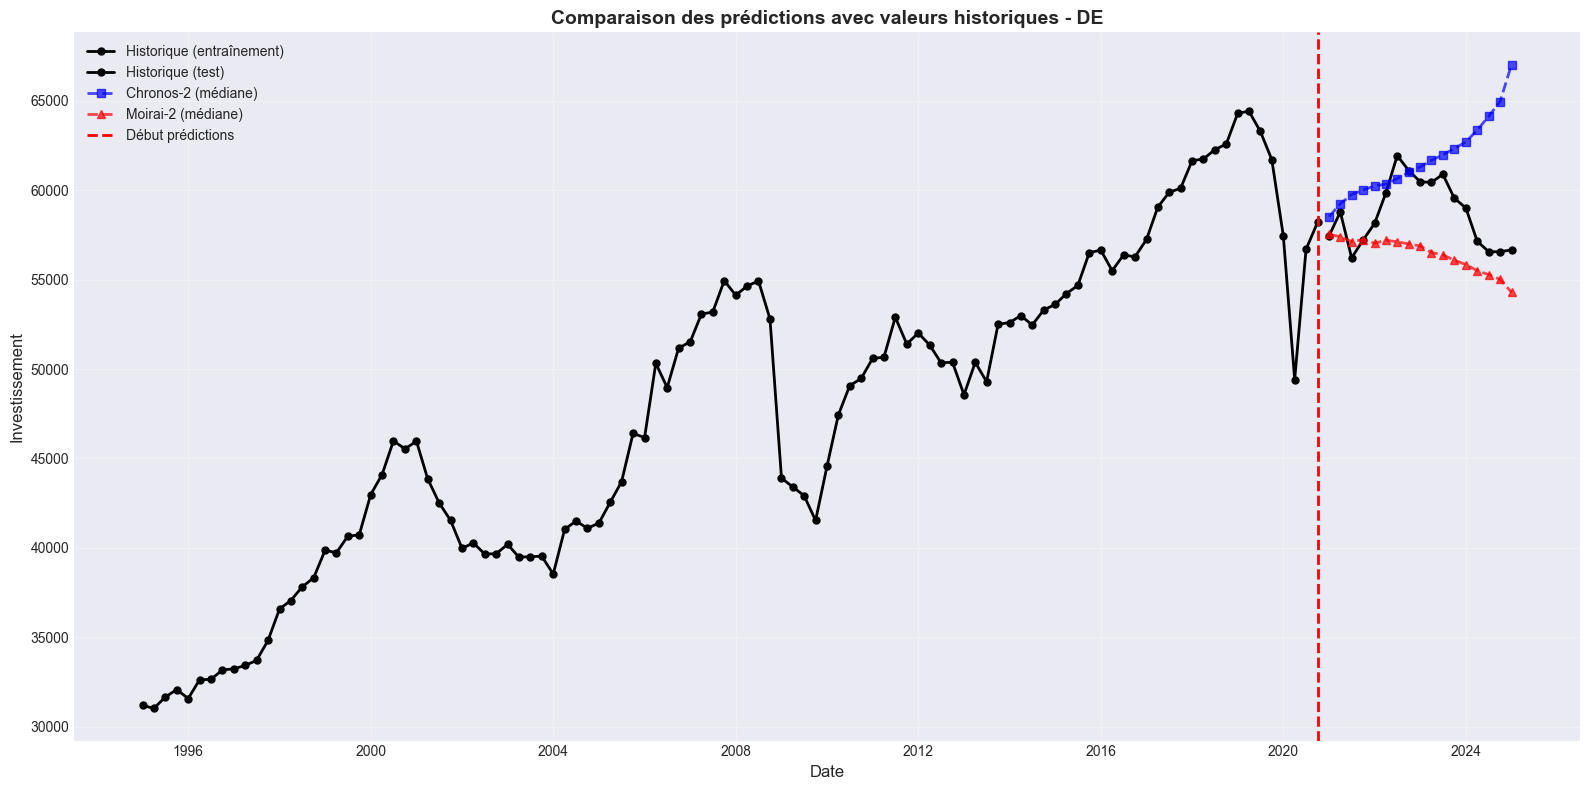

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))

# Données historiques
ax.plot(context_df[TIMESTAMP_COLUMN], context_df[TARGET_COLUMN], 
        'o-', linewidth=2, markersize=5, label='Historique (entraînement)', color='black')

# Valeurs historiques (période de prévision)
if 'actual' in merged_df.columns and merged_df['actual'].notna().any():
    actual_mask = merged_df['actual'].notna()
    ax.plot(merged_df.loc[actual_mask, TIMESTAMP_COLUMN], merged_df.loc[actual_mask, 'actual'], 
            'o-', linewidth=2, markersize=5, label='Historique (test)', 
            color='black')

# Prédictions Chronos
if 'chronos_p50' in merged_df.columns:
    ax.plot(merged_df[TIMESTAMP_COLUMN], merged_df['chronos_p50'], 
            's--', linewidth=2, markersize=6, label='Chronos-2 (médiane)', color='blue', alpha=0.7)

# Prédictions Moirai
if 'moirai_p50' in merged_df.columns:
    ax.plot(merged_df[TIMESTAMP_COLUMN], merged_df['moirai_p50'], 
            '^--', linewidth=2, markersize=6, label='Moirai-2 (médiane)', color='red', alpha=0.7)

# Ligne verticale pour séparer historique et prédictions
last_historical_date = context_df[TIMESTAMP_COLUMN].max()
ax.axvline(x=last_historical_date, color='red', linestyle='--', linewidth=2, label='Début prédictions')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Investissement', fontsize=12)
ax.set_title(f'Comparaison des prédictions avec valeurs historiques - {TARGET_COUNTRY}', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 10.2 Prédictions avec intervalles de confiance et Ground Truth


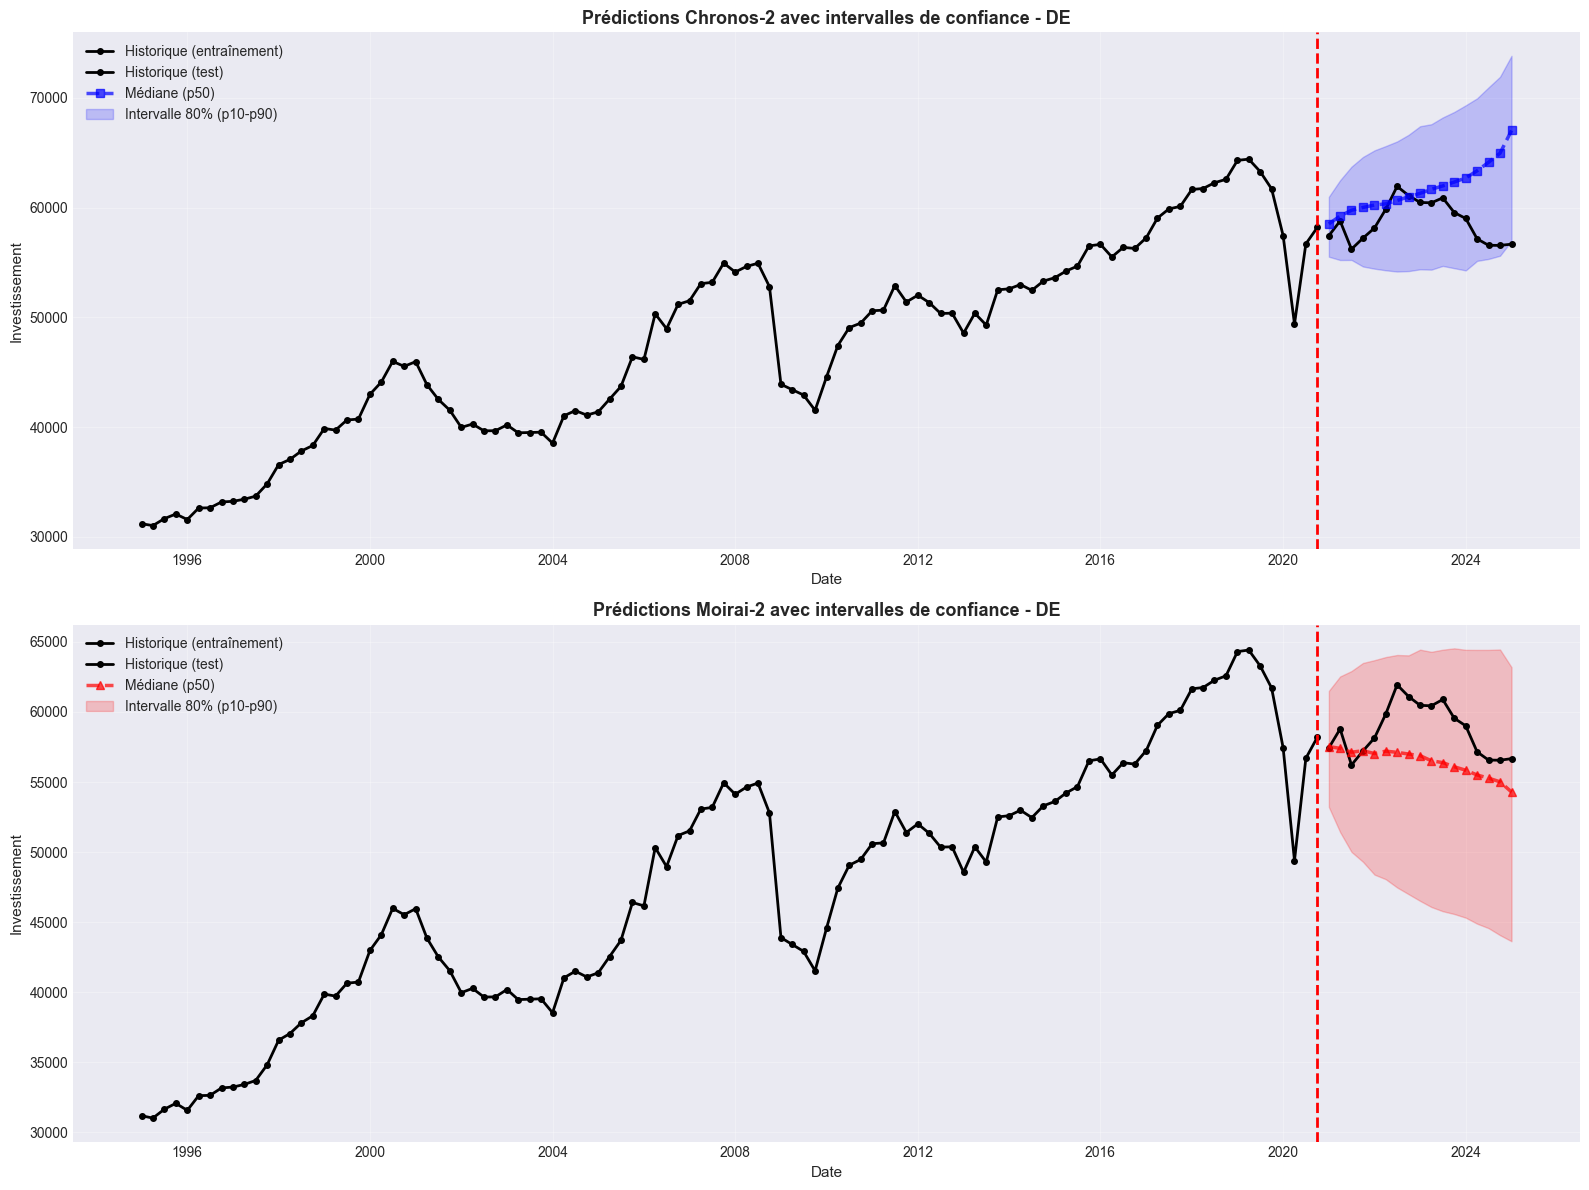

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# ========== Chronos-2 ==========
# Historique
ax1.plot(context_df[TIMESTAMP_COLUMN], context_df[TARGET_COLUMN], 
         'o-', linewidth=2, markersize=4, label='Historique (entraînement)', color='black')

# Valeurs historiques (période de test)
if 'actual' in merged_df.columns and merged_df['actual'].notna().any():
    actual_mask = merged_df['actual'].notna()
    ax1.plot(merged_df.loc[actual_mask, TIMESTAMP_COLUMN], merged_df.loc[actual_mask, 'actual'], 
             'o-', linewidth=2, markersize=4, label='Historique (test)', 
             color='black')

# Médiane
if 'chronos_p50' in merged_df.columns:
    ax1.plot(merged_df[TIMESTAMP_COLUMN], merged_df['chronos_p50'], 
             's--', linewidth=2.5, markersize=6, label='Médiane (p50)', color='blue', alpha=0.7)

# Intervalles de confiance
if 'chronos_p10' in merged_df.columns and 'chronos_p90' in merged_df.columns:
    ax1.fill_between(merged_df[TIMESTAMP_COLUMN], 
                     merged_df['chronos_p10'], 
                     merged_df['chronos_p90'],
                     alpha=0.2, color='blue', label='Intervalle 80% (p10-p90)')

ax1.axvline(x=last_historical_date, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Investissement', fontsize=11)
ax1.set_title(f'Prédictions Chronos-2 avec intervalles de confiance - {TARGET_COUNTRY}', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)

# ========== Moirai-2 ==========
# Historique
ax2.plot(context_df[TIMESTAMP_COLUMN], context_df[TARGET_COLUMN], 
         'o-', linewidth=2, markersize=4, label='Historique (entraînement)', color='black')

# Valeurs historiques (période de test)
if 'actual' in merged_df.columns and merged_df['actual'].notna().any():
    actual_mask = merged_df['actual'].notna()
    ax2.plot(merged_df.loc[actual_mask, TIMESTAMP_COLUMN], merged_df.loc[actual_mask, 'actual'], 
             'o-', linewidth=2, markersize=4, label='Historique (test)', 
             color='black')

# Médiane
if 'moirai_p50' in merged_df.columns:
    ax2.plot(merged_df[TIMESTAMP_COLUMN], merged_df['moirai_p50'], 
             '^--', linewidth=2.5, markersize=6, label='Médiane (p50)', color='red', alpha=0.7)

# Intervalles de confiance
if 'moirai_p10' in merged_df.columns and 'moirai_p90' in merged_df.columns:
    ax2.fill_between(merged_df[TIMESTAMP_COLUMN], 
                     merged_df['moirai_p10'], 
                     merged_df['moirai_p90'],
                     alpha=0.2, color='red', label='Intervalle 80% (p10-p90)')

ax2.axvline(x=last_historical_date, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Investissement', fontsize=11)
ax2.set_title(f'Prédictions Moirai-2 avec intervalles de confiance - {TARGET_COUNTRY}', 
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 10.3 Erreurs de prédiction par rapport au Ground Truth


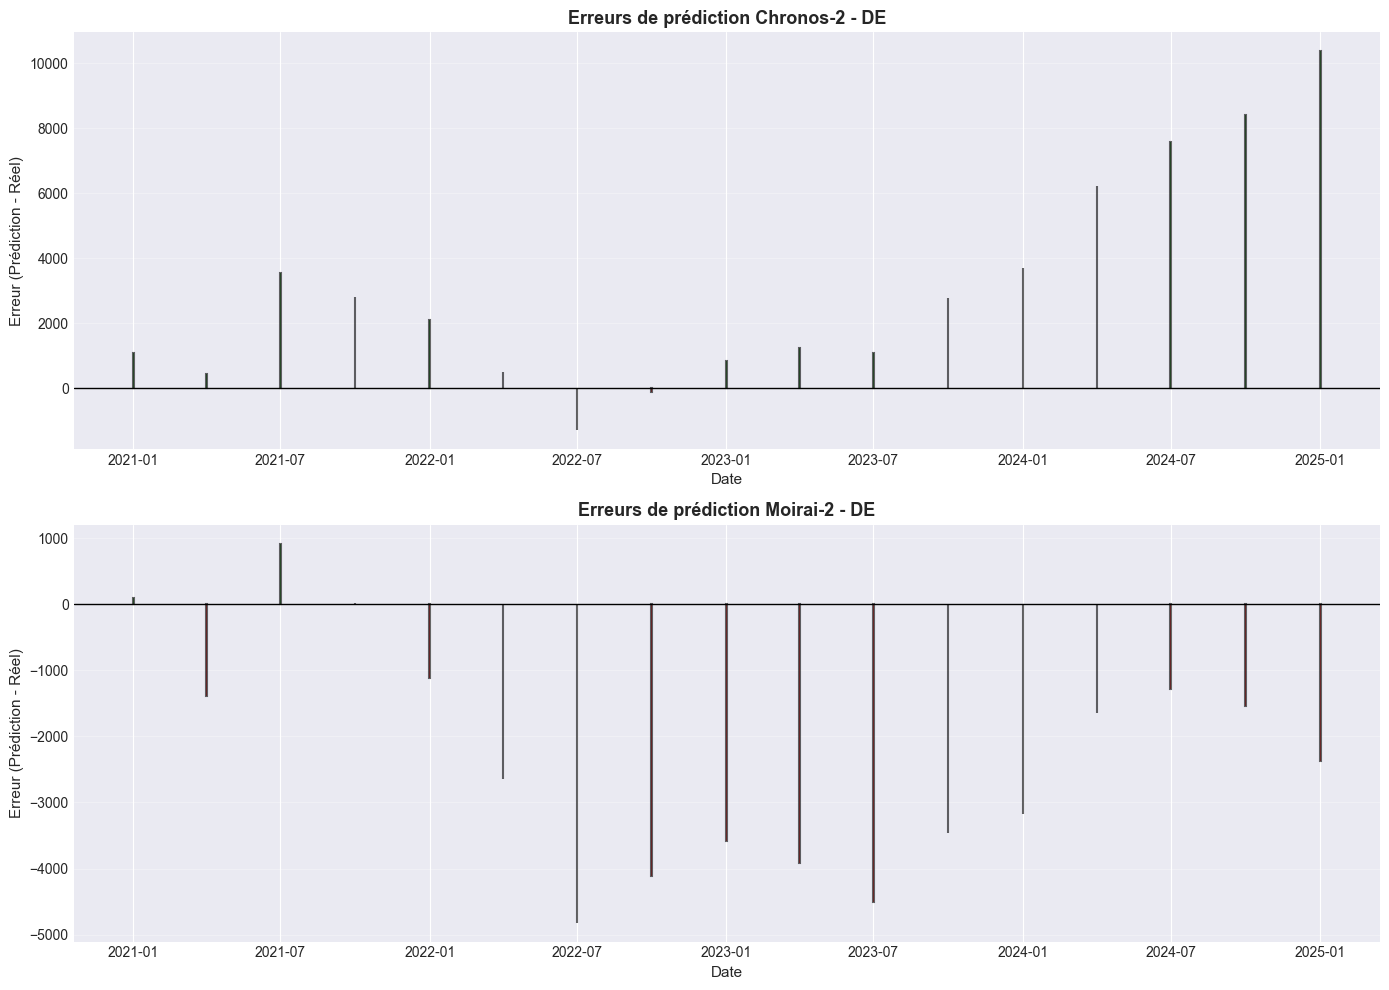


📊 Statistiques des erreurs:

🔵 Chronos-2:
  Erreur moyenne: 3012.13
  Erreur médiane: 2091.74
  Écart-type: 3280.60

🔴 Moirai-2:
  Erreur moyenne: -2268.51
  Erreur médiane: -2379.61
  Écart-type: 1707.21


In [15]:
if 'actual' in merged_df.columns and merged_df['actual'].notna().any():
    # Calculer les erreurs
    mask = merged_df['actual'].notna()
    merged_df['chronos_error'] = merged_df['chronos_p50'] - merged_df['actual']
    merged_df['moirai_error'] = merged_df['moirai_p50'] - merged_df['actual']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Graphique 1: Erreurs Chronos-2
    if 'chronos_error' in merged_df.columns:
        chronos_data = merged_df.loc[mask]
        colors_chronos = ['green' if x >= 0 else 'red' for x in chronos_data['chronos_error']]
        ax1.bar(chronos_data[TIMESTAMP_COLUMN], chronos_data['chronos_error'], 
               color=colors_chronos, alpha=0.6, edgecolor='black', linewidth=1.5)
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax1.set_xlabel('Date', fontsize=11)
        ax1.set_ylabel('Erreur (Prédiction - Réel)', fontsize=11)
        ax1.set_title(f'Erreurs de prédiction Chronos-2 - {TARGET_COUNTRY}', 
                     fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
    
    # Graphique 2: Erreurs Moirai-2
    if 'moirai_error' in merged_df.columns:
        moirai_data = merged_df.loc[mask]
        colors_moirai = ['green' if x >= 0 else 'red' for x in moirai_data['moirai_error']]
        ax2.bar(moirai_data[TIMESTAMP_COLUMN], moirai_data['moirai_error'], 
               color=colors_moirai, alpha=0.6, edgecolor='black', linewidth=1.5)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xlabel('Date', fontsize=11)
        ax2.set_ylabel('Erreur (Prédiction - Réel)', fontsize=11)
        ax2.set_title(f'Erreurs de prédiction Moirai-2 - {TARGET_COUNTRY}', 
                     fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques sur les erreurs
    print(f"\n📊 Statistiques des erreurs:\n")
    if 'chronos_error' in merged_df.columns:
        print(f"🔵 Chronos-2:")
        print(f"  Erreur moyenne: {merged_df.loc[mask, 'chronos_error'].mean():.2f}")
        print(f"  Erreur médiane: {merged_df.loc[mask, 'chronos_error'].median():.2f}")
        print(f"  Écart-type: {merged_df.loc[mask, 'chronos_error'].std():.2f}")
    
    if 'moirai_error' in merged_df.columns:
        print(f"\n🔴 Moirai-2:")
        print(f"  Erreur moyenne: {merged_df.loc[mask, 'moirai_error'].mean():.2f}")
        print(f"  Erreur médiane: {merged_df.loc[mask, 'moirai_error'].median():.2f}")
        print(f"  Écart-type: {merged_df.loc[mask, 'moirai_error'].std():.2f}")
else:
    print("⚠️ Aucune valeur réelle disponible pour calculer les erreurs")


### 10.4 Différences entre les modèles


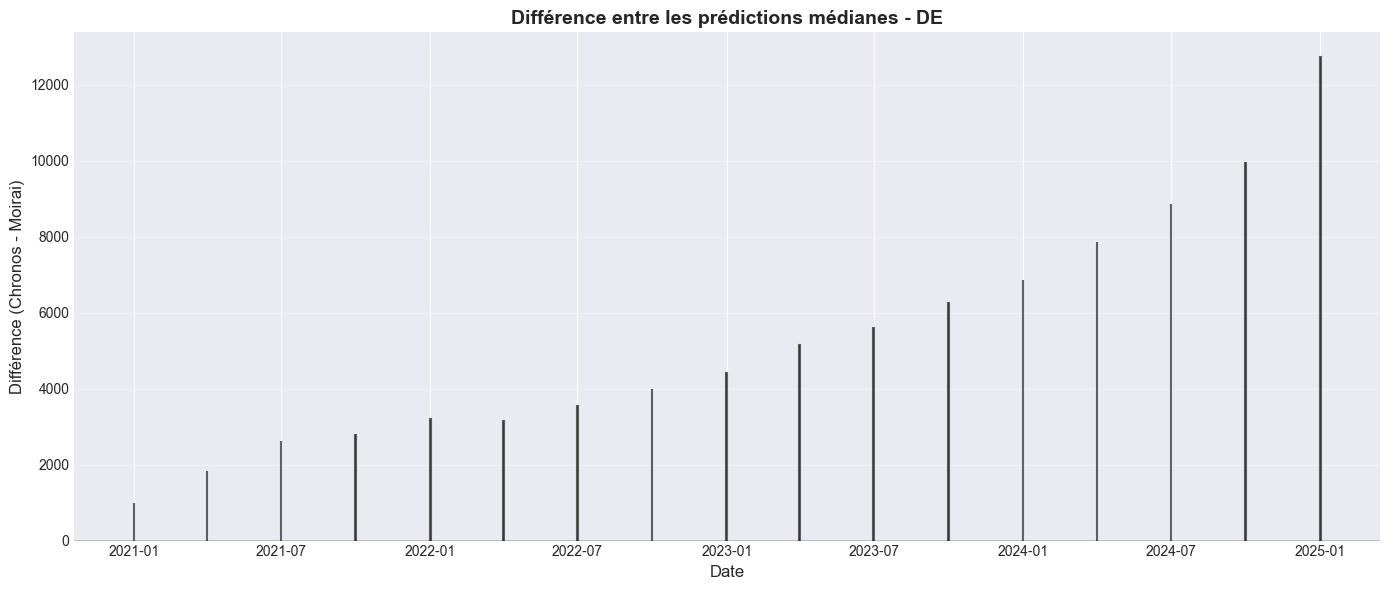


📊 Statistiques sur les différences:
  Moyenne: 5280.64
  Médiane: 4421.47
  Écart-type: 3145.01
  Min: 984.46
  Max: 12743.07


In [16]:
if 'delta_p50' in merged_df.columns:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    colors = ['green' if x >= 0 else 'red' for x in merged_df['delta_p50']]
    ax.bar(merged_df[TIMESTAMP_COLUMN], merged_df['delta_p50'], 
           color=colors, alpha=0.6, edgecolor='black', linewidth=1.5)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Différence (Chronos - Moirai)', fontsize=12)
    ax.set_title(f'Différence entre les prédictions médianes - {TARGET_COUNTRY}', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Statistiques sur les différences:")
    print(f"  Moyenne: {merged_df['delta_p50'].mean():.2f}")
    print(f"  Médiane: {merged_df['delta_p50'].median():.2f}")
    print(f"  Écart-type: {merged_df['delta_p50'].std():.2f}")
    print(f"  Min: {merged_df['delta_p50'].min():.2f}")
    print(f"  Max: {merged_df['delta_p50'].max():.2f}")


### 10.5 Distribution des échantillons Moirai (si disponible)


In [17]:
if moirai_result.samples is not None:
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))
    axes = axes.flatten()
    
    for i in range(min(PREDICTION_LENGTH, 8)):
        ax = axes[i]
        samples_at_t = moirai_result.samples[:, i]
        
        ax.hist(samples_at_t, bins=20, alpha=0.7, color='coral', edgecolor='black')
        ax.axvline(np.median(samples_at_t), color='red', linestyle='--', linewidth=2, label='Médiane')
        ax.axvline(np.mean(samples_at_t), color='blue', linestyle='--', linewidth=2, label='Moyenne')
        
        # Ajouter la valeur historique si disponible
        if 'actual' in merged_df.columns and pd.notna(merged_df.iloc[i]['actual']):
            actual_val = merged_df.iloc[i]['actual']
            ax.axvline(actual_val, color='gray', linestyle='-', linewidth=1.5, label='Historique', alpha=0.6)
        
        ax.set_title(f'T+{i+1}: {forecast_index[i].date()}', fontsize=10)
        ax.set_xlabel('Valeur prédite', fontsize=9)
        ax.set_ylabel('Fréquence', fontsize=9)
        if i == 0:
            ax.legend(fontsize=8)
    
    plt.suptitle(f'Distribution des échantillons Moirai-2 - {TARGET_COUNTRY}', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
else:
    print("ℹ️ Les échantillons Moirai ne sont pas disponibles pour la visualisation.")


ℹ️ Les échantillons Moirai ne sont pas disponibles pour la visualisation.


## 11. Export des résultats


In [18]:
# Sauvegarder les résultats
output_dir = project_root / "results"
output_dir.mkdir(exist_ok=True)

output_file = output_dir / f"predictions_{TARGET_COUNTRY}_{PREDICTION_LENGTH}q.csv"
merged_df.to_csv(output_file, index=False)

print(f"💾 Résultats sauvegardés dans: {output_file}")
print(f"\n📋 Contenu du fichier:")
print(merged_df.to_string())


💾 Résultats sauvegardés dans: /Users/matthieualcouffe/projet/ECB_Forecast/results/predictions_DE_17q.csv

📋 Contenu du fichier:
    timestamp   chronos_p10   chronos_p50   chronos_p90    moirai_p10    moirai_p50    moirai_p90   moirai_mean     delta_p50    actual  chronos_error  moirai_error
0  2021-01-01  55524.835938  58518.828125  60987.937500  53215.886719  57534.367188  61504.871094  57534.367188    984.460938  57443.01    1075.818125     91.357187
1  2021-04-01  55224.957031  59236.386719  62497.253906  51428.304688  57400.113281  62532.062500  57400.113281   1836.273438  58786.93     449.456719  -1386.816719
2  2021-07-01  55231.289062  59757.898438  63732.390625  50014.484375  57129.488281  62919.664062  57129.488281   2628.410156  56216.19    3541.708437    913.298281
3  2021-10-01  54633.203125  60014.652344  64617.085938  49307.007812  57231.507812  63496.878906  57231.507812   2783.144531  57219.96    2794.692344     11.547813
4  2022-01-01  54435.832031  60237.394531  6521

## 12. Résumé et conclusions


In [19]:
print("=" * 80)
print("📊 RÉSUMÉ DES PRÉDICTIONS")
print("=" * 80)
print(f"\n🎯 Pays: {TARGET_COUNTRY}")
print(f"📅 Horizon: {PREDICTION_LENGTH} trimestres ({forecast_index[0].date()} → {forecast_index[-1].date()})")
print(f"\n⏱️ Performance:")
print(f"  • Chronos-2: {chronos_result.elapsed_s:.2f}s")
print(f"  • Moirai-2:  {moirai_result.elapsed_s:.2f}s")

if 'chronos_p50' in merged_df.columns and 'moirai_p50' in merged_df.columns:
    print(f"\n📈 Prédictions médianes:")
    print(f"  • Chronos-2: {merged_df['chronos_p50'].mean():.2f} (moyenne)")
    print(f"  • Moirai-2:  {merged_df['moirai_p50'].mean():.2f} (moyenne)")
    print(f"  • Différence: {merged_df['chronos_p50'].mean() - merged_df['moirai_p50'].mean():.2f}")

print(f"\n📊 Dernière valeur historique: {context_df[TARGET_COLUMN].iloc[-1]:.2f}")
print(f"📅 Date: {context_df[TIMESTAMP_COLUMN].iloc[-1].date()}")

# Ajouter les métriques avec ground truth
if 'actual' in merged_df.columns and merged_df['actual'].notna().any():
    mask = merged_df['actual'].notna()
    print(f"\n🎯 Performance vs Ground Truth ({mask.sum()} points):")
    
    if 'chronos_p50' in merged_df.columns:
        chronos_mae = np.abs(merged_df.loc[mask, 'chronos_p50'] - merged_df.loc[mask, 'actual']).mean()
        chronos_mape = (np.abs((merged_df.loc[mask, 'actual'] - merged_df.loc[mask, 'chronos_p50']) / merged_df.loc[mask, 'actual']).mean() * 100)
        print(f"  • Chronos-2 MAE: {chronos_mae:.2f} | MAPE: {chronos_mape:.2f}%")
    
    if 'moirai_p50' in merged_df.columns:
        moirai_mae = np.abs(merged_df.loc[mask, 'moirai_p50'] - merged_df.loc[mask, 'actual']).mean()
        moirai_mape = (np.abs((merged_df.loc[mask, 'actual'] - merged_df.loc[mask, 'moirai_p50']) / merged_df.loc[mask, 'actual']).mean() * 100)
        print(f"  • Moirai-2 MAE:  {moirai_mae:.2f} | MAPE: {moirai_mape:.2f}%")

print(f"\n✅ Analyse terminée!")
print("=" * 80)


📊 RÉSUMÉ DES PRÉDICTIONS

🎯 Pays: DE
📅 Horizon: 17 trimestres (2021-01-01 → 2025-01-01)

⏱️ Performance:
  • Chronos-2: 3.49s
  • Moirai-2:  0.01s

📈 Prédictions médianes:
  • Chronos-2: 61718.70 (moyenne)
  • Moirai-2:  56438.05 (moyenne)
  • Différence: 5280.65

📊 Dernière valeur historique: 58197.29
📅 Date: 2020-10-01

🎯 Performance vs Ground Truth (17 points):
  • Chronos-2 MAE: 3176.37 | MAPE: 5.53%
  • Moirai-2 MAE:  2388.06 | MAPE: 4.01%

✅ Analyse terminée!


---

## 📝 Notes

### Modèles utilisés:
- **Chronos-2**: Modèle de prévision de séries temporelles pré-entraîné sur un large corpus
- **Moirai-2**: Modèle de langage adapté pour les séries temporelles avec génération stochastique

### Paramètres importants:
- **Quantiles**: Permettent de capturer l'incertitude des prédictions
- **Temperature**: Contrôle l'aléatoire dans la génération Moirai (plus élevé = plus de variabilité)
- **Samples**: Nombre de trajectoires générées par Moirai pour estimer les quantiles

### Pour aller plus loin:
- Tester différents pays en changeant `TARGET_COUNTRY`
- Ajuster l'horizon de prédiction avec `PREDICTION_LENGTH`
- Expérimenter avec les paramètres de génération (temperature, top_p, top_k)
- Comparer les prédictions avec les valeurs réelles lorsque disponibles
